In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from konlpy.tag import Mecab,Okt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

In [2]:
# 데이터 불러오기
data = pd.read_csv('./data/train.csv')
data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
# class 열을 숫자로 변환
encoder = LabelEncoder()
data['class'] = encoder.fit_transform(data['class'])

In [4]:
# konlpy의 Mecab을 이용한 토큰화
mecab = Okt()
data['conversation'] = data['conversation'].apply(mecab.morphs)
#data['conversation'] = [mecab.morphs(sentence) for sentence in data['conversation']]

In [5]:
data.head()

,idx,class,conversation
0,0,3,"[지금, 너, 스스로, 를, 죽여, 달라, 고, 애원, 하는, 것, 인가, ?, \..."
1,1,3,"[길동, 경찰서, 입니다, ., \n, 9시, 40분, 마트, 에, 폭발물, 을, ..."
2,2,1,"[너, 되게, 귀여운거, 알, 지, ?, 나, 보다, 작은, 남자, 는, 첨, 봤어..."
3,3,0,"[어이, 거기, \n, 예, ??, \n, 너, 말, 이야, 너, ., 이리, 오라..."
4,4,0,"[저기, 요, 혹시, 날, 이, 너무, 뜨겁잖아요, ?, 저희, 회사, 에서, 이,..."


In [6]:
# 케라스를 이용한 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['conversation'])
sequences = tokenizer.texts_to_sequences(data['conversation'])

In [7]:
# 입력 데이터 패딩 처리 
#data_pad = pad_sequences(sequences)   #hjnam

#hjnam
word_index = tokenizer.word_index
index_word = {idx: word for word, idx in word_index.items()}
data_pad = [[index_word[idx] for idx in seq if idx != 0] for seq in sequences]

In [8]:
print(len(data_pad[0]))

108


In [9]:
from gensim.models import FastText
fasttext_model = FastText(data_pad, window=5, min_count=5, workers=4, sg=1)

embedding_dim = fasttext_model.vector_size

for i in range(4,vocab_size):
                if index_word[i] in fasttext_model.wv:
                embedding_matrix[i] = fasttext_model.wv[index_word[i]]
            

In [10]:
data_embeddings = []

for tokens in data_pad:
    sample_vectors = []
    
    for token in tokens:
        if token in fasttext_model.wv:
            word_vector = fasttext_model.wv.get_vector(token)
            sample_vectors.append(word_vector)
    
    # Add the sample vectors to the list of embeddings
    data_embeddings.append(sample_vectors)

# Pad the sequences of word vectors to have the same length
max_length = max(len(sample) for sample in data_embeddings)
data_embeddings = pad_sequences(data_embeddings, maxlen=max_length, dtype='float32')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_embeddings, data['class'], test_size=0.2, random_state=42)


In [11]:
def get_mlp():
    # MLP 모델 생성
    model = Sequential()
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=data_pad.shape[1]))
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=len(data_pad)))  #hjnam
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(data['class'].unique()), activation='softmax'))
    return model

In [12]:
max_length, embedding_dim

(359, 100)

In [13]:
model = get_mlp()
model.build(input_shape=(None, max_length, embedding_dim))  #hjnam
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 35900)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2297664   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 2,297,924
Trainable params: 2,297,924
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras.layers import Conv1D, GlobalMaxPooling1D

def get_cnn():
    # CNN 모델 생성
    model = Sequential()
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=data_pad.shape[1]))
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=len(data_pad))) #hjnam
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(data['class'].unique()), activation='softmax'))

    return model


In [15]:
model = get_cnn()
model.build(input_shape=(None, max_length, embedding_dim))  #hjnam
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 355, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 72,644
Trainable params: 72,644
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras.layers import LSTM, Dropout
from keras.layers import Input, Reshape

def get_lstm():
    # LSTM 모델 생성
    model = Sequential()
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=data_pad.shape[1]))
    #model.add(Embedding(len(tokenizer.word_index)+1, 128, input_length=tokenized.shape[1]))
    #model.add(Input(shape=(len(tokenizer.word_index)+1, vector_size)))
    #model.add(Input(shape=(vector_size))) #hjnam
    #model.add(Reshape((1, vector_size))) #hjnam
    #model.add(Reshape((vector_size))) #hjnam
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(len(data['class'].unique()), activation='softmax'))

    return model


In [17]:
model = get_lstm()
model.build(input_shape=(None, max_length, embedding_dim))  #hjnam
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 46,660
Trainable params: 46,660
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
len(X_train), len(y_train)

(3160, 3160)

In [20]:
# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
99/99 [==============================] - 8s 41ms/step - loss: 1.0021 - accuracy: 0.5763 - val_loss: 0.8191 - val_accuracy: 0.6582
Epoch 2/30
99/99 [==============================] - 1s 14ms/step - loss: 0.6981 - accuracy: 0.7532 - val_loss: 0.6519 - val_accuracy: 0.7696
Epoch 3/30
99/99 [==============================] - 2s 17ms/step - loss: 0.6148 - accuracy: 0.7791 - val_loss: 0.5887 - val_accuracy: 0.7886
Epoch 4/30
99/99 [==============================] - 1s 14ms/step - loss: 0.6053 - accuracy: 0.7848 - val_loss: 0.5615 - val_accuracy: 0.8025
Epoch 5/30
99/99 [==============================] - 1s 14ms/step - loss: 0.5843 - accuracy: 0.7994 - val_loss: 0.5962 - val_accuracy: 0.7873
Epoch 6/30
99/99 [==============================] - 1s 14ms/step - loss: 0.5380 - accuracy: 0.8092 - val_loss: 0.6312 - val_accuracy: 0.7443
Epoch 7/30
99/99 [==============================] - 1s 14ms/step - loss: 0.5676 - accuracy: 0.8022 - val_loss: 0.5479 - val_accuracy: 0.7937
Epoch 8/30
99

In [21]:
def train(get_model):
    model = get_model()
    model.summary()
    # 모델 컴파일
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # 모델 학습
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)
    return model, history

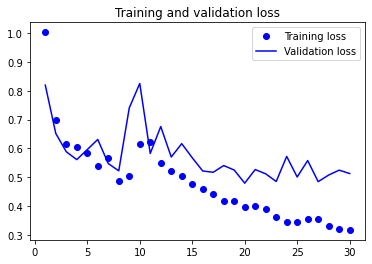

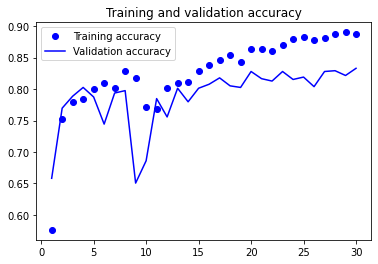

In [22]:
import matplotlib.pyplot as plt

def visualization(history):
    # 시각화를 위한 데이터 정의
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    # 손실값 시각화
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    # 정확도 시각화
    plt.figure()
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.show()

visualization(history)


### Testing

In [23]:
def test_routine(model):
    #predictions = model.predict(test_pad)
    predictions = model.predict(word_vectors)  #hjnam
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = encoder.inverse_transform(predicted_classes)
    print(predicted_labels)

In [26]:
#hjnam
df2 = pd.read_csv('./data/output.csv')
s1 = df2['text']
s2 = df2['class']
df3 = pd.concat([s1, s2], axis=1)
df3 = df3.fillna(value=' ')
df3 = df3.dropna()

df3['text'] = df3['text'].apply(mecab.morphs)

max_words = 10000

# Tokenizer를 생성하고 텍스트 데이터에 적합시킵니다.
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df3['text'])

test_sequences = tokenizer.texts_to_sequences(df3['text'])
word_index = tokenizer.word_index
index_word = {idx: word for word, idx in word_index.items()}
recovered = [[index_word[idx] for idx in seq if idx != 0] for seq in test_sequences]
data_embeddings = [[fasttext_model.wv.get_vector(word) for word in sentence] for sentence in recovered]


max_length = max(len(sample) for sample in data_embeddings)
data_embeddings = pad_sequences(data_embeddings, maxlen=max_length, dtype='float32')

fasttext_model.wv.get_vector('갔다오면')

word_vectors = np.array(data_embeddings)
predictions = model.predict(word_vectors)

predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = encoder.inverse_transform(predicted_classes)
predicted_labels


array(['갈취 대화', '직장 내 괴롭힘 대화', '직장 내 괴롭힘 대화', '직장 내 괴롭힘 대화', '협박 대화',
       '협박 대화', '갈취 대화', '갈취 대화', '협박 대화', '직장 내 괴롭힘 대화', '직장 내 괴롭힘 대화',
       '갈취 대화', '협박 대화', '기타 괴롭힘 대화', '협박 대화', '기타 괴롭힘 대화', '기타 괴롭힘 대화',
       '갈취 대화', '갈취 대화', '직장 내 괴롭힘 대화', '직장 내 괴롭힘 대화', '갈취 대화', '협박 대화',
       '갈취 대화', '기타 괴롭힘 대화', '갈취 대화', '기타 괴롭힘 대화', '갈취 대화', '협박 대화',
       '갈취 대화', '협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화',
       '협박 대화', '기타 괴롭힘 대화', '협박 대화', '갈취 대화', '기타 괴롭힘 대화', '갈취 대화',
       '직장 내 괴롭힘 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '기타 괴롭힘 대화',
       '기타 괴롭힘 대화', '기타 괴롭힘 대화', '갈취 대화', '기타 괴롭힘 대화', '협박 대화',
       '기타 괴롭힘 대화', '직장 내 괴롭힘 대화', '협박 대화', '기타 괴롭힘 대화', '기타 괴롭힘 대화',
       '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '직장 내 괴롭힘 대화', '협박 대화',
       '직장 내 괴롭힘 대화', '갈취 대화', '기타 괴롭힘 대화', '협박 대화', '협박 대화', '기타 괴롭힘 대화',
       '직장 내 괴롭힘 대화', '갈취 대화', '갈취 대화', '직장 내 괴롭힘 대화', '직장 내 괴롭힘 대화',
       '협박 대화', '기타 괴롭힘 대화', '직장 내 괴롭힘 대화', '직장 내 괴롭힘 대화', '갈취 대화',
       '직장 내 괴롭힘 대화', 